## Setup environment

In [2]:
!pip install -q --upgrade pip
!pip install -q sagemaker==2.16.2
!pip install -q jsonlines

In [1]:
import cv2
import sagemaker
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base

import visualization_utils as viz_utils

In [3]:
from sagemaker.tensorflow import TensorFlowModel
#from sagemaker.tensorflow.model import TensorFlowModel
#from sagemaker.tensorflow.serving import Model

In [4]:
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role() 

bucket = sagemaker_session.default_bucket() 

In [7]:
model_artifact = 'S3 uri to model'

## Create endpoint

In [11]:
model = TensorFlowModel(
    name=name_from_base('abd-tf2-object-detection-maskdetection'),
    model_data=model_artifact,
    role=role,
    framework_version='2.3'
)

In [13]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---!

## Predict

In [14]:
def image_file_to_tensor(path):
    cv_img = cv2.imread(path,1).astype('uint8')
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return cv_img

In [36]:
img = image_file_to_tensor('test_images/mask002.jpg')

input = {
  'instances': [img.tolist()]
}

detections = predictor.predict(input)['predictions'][0]

In [38]:
detections.keys()

dict_keys(['raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores'])

In [40]:
img_with_detections = img.copy()
category_index = {1:{'id': 1, 'name': 'mask'}, 2:{'id': 2, 'name': 'no-mask'}}
detection_boxes = np.array(detections['detection_boxes'])
detection_classes = [int(x) for x in detections['detection_classes']]
detection_scores = detections['detection_scores']

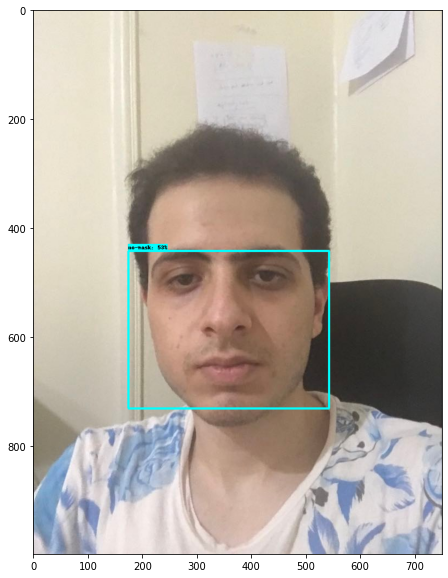

In [41]:
%matplotlib inline

viz_utils.visualize_boxes_and_labels_on_image_array(
    img_with_detections,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=100,
    min_score_thresh=0.2,
    agnostic_mode=False)

plt.figure(figsize=(10,10))
plt.imshow(img_with_detections)
plt.show()

## Delete endpoint

In [42]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
